<a href="https://colab.research.google.com/github/tluxxx/CandleStickStudies/blob/main/StudiesOnCandleSticks01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Studies on Candle-Sticks

# 1. Preparations

In [1]:
# importing TA-Lib
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4039    0  4039    0     0   9450      0 --:--:-- --:--:-- --:--:--  9436
100  517k  100  517k    0     0   412k      0  0:00:01  0:00:01 --:--:--  412k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4035    0  4035    0     0   8201      0 --:--:-- --:--:-- --:--:--  8217
100  392k  100  392k    0     0   369k      0  0:00:01  0:00:01 --:--:-- 1481k


In [2]:
# import of modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from datetime import date
import yfinance as yf
from tqdm import tqdm
import scipy.stats as st
import statsmodels.api as sm


In [4]:
# download data
prices = yf.download('^GDAXI', start='2000-01-01', end='2024-06-09')

[*********************100%%**********************]  1 of 1 completed


# 2. Overview and Basic Statistics of Occurences

In [5]:
# identification of candle patterns
candle_names = talib.get_function_groups()['Pattern Recognition']

# defining the look_ahead-intervall and forming reduced price dataframe without last day_look_ahead-prices
days_look_ahead = 20
days = list(range(days_look_ahead + 1))
idx = prices.index[0:-(days_look_ahead + 1)]
prices_red = prices[prices.index.isin(idx)]

# counting of occurence of signals per candle pattern
cp = pd.DataFrame(index=prices_red.index)
type_ = [-200, -100, 100, 200]
cp_stat = pd.DataFrame(columns=candle_names, index=type_)

# nb of occurance of (candles, type)-combinations
for candle in candle_names:
  cp[candle] = getattr(talib, candle)(prices_red.Open, prices_red.High, prices_red.Low, prices_red.Close)
  for tp in type_:
    cp_stat.loc[tp, candle] = cp[cp[candle] == tp][candle].count()

# total occurence per patterns
cp_stat_tr = cp_stat.T
cp_stat_tr['occurence'] = cp_stat_tr.sum(axis=1)
cp_stat_tr.sort_values('occurence', inplace=True, ascending=False)

# identification of most active candle-patterns (i.e more than 100 signals per pattern and type)
X = 100
most_active = cp_stat_tr[(cp_stat_tr.iloc[:,0] > X) | (cp_stat_tr.iloc[:,1] > X) | (cp_stat_tr.iloc[:,2] > X) | (cp_stat_tr.iloc[:,3] > X)]

In [6]:
# Bar-Chart showing the occurence of all patterns
main_title = '# of occurences of single candle-pattterns'
sub_title = 'instrument: DAX,  duration: 2000-01-01 - 2024-06-09'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# plotting
fig = go.Figure()
for tp in type_:
  y_x = (cp_stat_tr.loc[:, tp].tolist())
  fig.add_trace(go.Bar(x=candle_names, y=y_x, name = tp))
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='candle-pattern', yaxis_title='# of occurences', legend_title="Signals from TA-LIB")
fig.update_layout(barmode='stack')
fig.update_xaxes(tickangle= -90)
fig.show()

In [7]:
# Bar-Chart showing the most active patterns
main_title = '# of occurences of most active candle patterns (# of combination (cp,tp) > 100)'
sub_title = 'instrument: DAX,  duration: 2000-01-01 - 2024-06-09'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# plotting
fig = go.Figure()
for tp in type_:
  y_x = most_active.loc[:, tp].tolist()
  fig.add_trace(go.Bar(x=most_active.index, y=y_x, name=tp))
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='candle-pattern', yaxis_title='# of occurences', legend_title="Signals from TA-LIB")
fig.update_layout(barmode='stack')
fig.update_xaxes(tickangle= -90)
fig.show()

# 3. calculation of post-candle-signal-trajectories for price, returns and cumulated returns, stored in data-frame

In [8]:
# trajectories (price, returns and cumulated returns) collected in sortable dataframes in rows

# preparations
top_candle_names = most_active.index.tolist()

# initialisation
traject_1 = pd.DataFrame()
pt_id = 0

for candle in tqdm(top_candle_names):
  # identification of dates and indexes of occurence of "candle"
  x = cp[cp[candle] != 0][candle]
  idx = x.index.tolist()
  indxs = prices.index.tolist()
  # looping through the identfied occurences
  for id  in idx:
    # preparations
    typ = x.loc[id]
    pt_id += 1
    # identification of the intervall between occurence and + day_look_ahead, calculation rets/cumrets
    id_s = indxs.index(id)
    id_x = indxs[id_s: id_s + days_look_ahead + 1]
    pr_x = prices[prices.index.isin(id_x)]['Close']
    rets_x = pr_x.pct_change().fillna(0)
    cumrets_x = (1 + rets_x).cumprod()
    # transfering into a data-frame and connecting to the previous data
    dict_df =  {'pattern': [candle] * (days_look_ahead + 1),
                'tp': [typ] * (days_look_ahead + 1),
                'pattern_id':[pt_id] * (days_look_ahead + 1),
                'day': days,
                'rets':rets_x.to_list(),
                'cumrets':cumrets_x.to_list()}
    tr_x = pd.DataFrame(dict_df)
    traject_1 = pd.concat([traject_1, tr_x], axis=0)


100%|██████████| 17/17 [01:09<00:00,  4.09s/it]


In [9]:
# alternate sorting of trajectory-data in a dataframe
# per occurence of a pattern all related cumrets-data during days_look_ahead-period in one row and several columns

# list of identified candle-patterns
pt_nbs = traject_1['pattern_id'].unique().tolist()

# preparation of the dataframe
cols = ['pattern_id', 'pattern', 'tp'] + days
traject_2 = pd.DataFrame(columns=cols)
rows=[]

# iteration through every occurance of every pattern
for pt in tqdm(pt_nbs):
  # basic pattern data per occurence
  tr = traject_1[traject_1['pattern_id'] == pt]
  tr1 = tr[(tr['day'] == 0)]
  row = tr1['pattern_id'].tolist() + tr1['pattern'].tolist() + tr1['tp'].tolist()
  # iteratiou through the days_look_ahead intervall (following the moment of occurence) and collection of data in a row
  for day in days:
    tr2 = tr[tr['day'] == day]
    row = row + tr2['cumrets'].tolist()
  rows.append(row)

# compilation of the final data-frame
traject_2 = pd.DataFrame(rows, columns=cols)

100%|██████████| 11343/11343 [02:19<00:00, 81.58it/s]


# 4. Statistical Analyses

## 4.1. # occurences of the most active combinations (candle patterns, signal-type/ mode)

In [10]:
# number of occurences of combinations (patterns, signal-type)
tr = traject_1[traject_1['day'] == 0].groupby(['pattern','tp']).count()['rets']
trx = tr.sort_values(ascending=False)
trx

pattern             tp  
CDLDOJI              100    848
CDLLONGLEGGEDDOJI    100    848
CDLLONGLINE          100    757
CDLSPINNINGTOP       100    681
                    -100    671
CDLRICKSHAWMAN       100    667
CDLBELTHOLD          100    613
CDLCLOSINGMARUBOZU   100    570
CDLBELTHOLD         -100    560
CDLLONGLINE         -100    550
CDLSHORTLINE         100    423
CDLHIGHWAVE          100    393
                    -100    390
CDLCLOSINGMARUBOZU  -100    354
CDLHIKKAKE          -100    314
CDLHARAMI            100    295
CDLSHORTLINE        -100    295
CDLMARUBOZU          100    253
CDLHARAMI           -100    250
CDLENGULFING        -100    239
CDLHIKKAKE           100    218
CDLENGULFING         100    200
CDLHAMMER            100    158
CDLMARUBOZU         -100    146
CDLHANGINGMAN       -100    132
CDL3OUTSIDE         -100    110
CDLDOJISTAR         -100    107
CDL3OUTSIDE          100     94
CDLHIKKAKE          -200     82
                     200     68
CDLDOJISTAR    

In [52]:
# cumrets after x days and bullish/bearisch-filter

mode = 'bearish' # or bearish
days_analyzed = [1, 5, 10, 15, 20]

# preparations
names=[]
cumrets = []
days_str_analyzed = ['day +' + str(days_analyzed[i]) for i in range(len(days_analyzed))]
tpx = [100, 200] if mode == 'bullish' else [-100, -200]

for day in days_analyzed:
  tr = traject_1[((traject_1['tp'] == tpx[0]) | (traject_1['tp'] == tpx[1])) & (traject_1['day'] == day)]
  trx = tr.groupby(['pattern','tp']).mean()['cumrets'].sort_values(ascending = False)
  if mode == 'bullish':
    trx = trx.sort_values(ascending = False).round(decimals=5)
  elif mode == 'bearish':
    trx = trx.sort_values(ascending = True).round(decimals=5)
  names.append(trx.index.to_flat_index().tolist())
  cumrets.append(trx.tolist())

# collecting the results in an dataframe
results = pd.DataFrame()

for i, day in enumerate(days_analyzed):
  key_1 = f'pattern + {day}'
  key_2 = f'cumrets + {day}'
  df_x = pd.DataFrame({key_1: names[i], key_2: cumrets[i]})
  results = pd.concat([results, df_x], axis=1)
results[0:4]


,pattern + 1,cumrets + 1,pattern + 5,cumrets + 5,pattern + 10,cumrets + 10,pattern + 15,cumrets + 15,pattern + 20,cumrets + 20
0,"(CDLDOJISTAR, -100)",0.99899,"(CDLMARUBOZU, -100)",0.99729,"(CDLHIKKAKE, -100)",0.99746,"(CDLDOJISTAR, -100)",0.99772,"(CDLDOJISTAR, -100)",0.99705
1,"(CDLLONGLINE, -100)",0.99903,"(CDLHIKKAKE, -200)",0.99768,"(CDLHANGINGMAN, -100)",0.99816,"(CDLHIKKAKE, -100)",0.99846,"(CDLMARUBOZU, -100)",0.99833
2,"(CDL3OUTSIDE, -100)",0.99918,"(CDLHIKKAKE, -100)",0.99888,"(CDLMARUBOZU, -100)",1.00034,"(CDLMARUBOZU, -100)",0.99860,"(CDLHIKKAKE, -100)",1.00050
3,"(CDLSHORTLINE, -100)",0.99918,"(CDLLONGLINE, -100)",0.99919,"(CDLDOJISTAR, -100)",1.00052,"(CDLHANGINGMAN, -100)",0.99970,"(CDL3OUTSIDE, -100)",1.00097


In [53]:
# list of best patterns
# sowing only the names and types
x = results.iloc[0:4, [0, 2, 4, 6, 8]]
top_patterns = []
# separating the names of the patterns
for i in range(x.shape[0]):
  for j in range(x.shape[1]):
    top_patterns = top_patterns + [x.iloc[i,j][0]]
# removing double entries
top_patterns = list(set(top_patterns))
top_patterns

['CDLHANGINGMAN',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'CDLDOJISTAR',
 'CDLHIKKAKE',
 'CDL3OUTSIDE',
 'CDLMARUBOZU']

## 4.2. Development of positions over time (average trajectories for top patterns)

In [54]:
# mittlere cumrets per day in days_look_ahead-period, final flattening the multi-index
tr_avg = traject_2.groupby(['pattern', 'tp']).mean()
tr_avg.reset_index(inplace=True)

In [55]:
# displaying the average position development for the top active patterns
main_title = f'trajectories of average PnL-development of positions after occurence of {mode} candle-patterns'
sub_title = f'instrument: DAX,  duration: 2000-01-01 - 2024-06-09'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# preparations
tr = tr_avg[(tr_avg['tp'] == tpx[0]) | (tr_avg['tp'] == tpx[1])]
idx = tr.index

# plotting
fig = go.Figure()
# looping through all available patterns in the required mode and collecting the cumrets during look_ahead-period
for id in idx:
  y_x = []
  n_1 = tr.loc[id,'pattern']
  n_2 = tr.loc[id,'tp']
  for day in days:
    y_x.append(tr.loc[id,day])
  fig.add_trace(go.Scatter(x=days, y=y_x, name=f'{n_1} & {n_2}'))
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='days after occurence of a pattern', yaxis_title='# PnL of position', legend_title='candle pattern')
fig.update_xaxes(tickangle= -90)
fig.show()

## 4.3 development of positions over times (trajectories for selected patterns and modes)

In [56]:
# selection of pattern
# top patterns bullish: ['CDLHARAMI','CDLHAMMER','CDLSHORTLINE','CDLDOJISTAR','CDLHIKKAKE','CDLENGULFING','CDL3OUTSIDE']
# top patterns bearish: ['CDLHANGINGMAN','CDLSHORTLINE','CDLLONGLINE','CDLDOJISTAR','CDLHIKKAKE','CDL3OUTSIDE','CDLMARUBOZU']

candle = top_patterns[1]

In [57]:
# development for selected patterns over time - BOX-plot
main_title = 'PnL-development of positions after occurences of a combination (candle patterns, mode)'
sub_title = f'instrument: DAX,  duration: 2000-01-01 - 2024-06-09   candle pattern: {candle}, mode: {mode}'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# preparation
p_x = traject_1[(traject_1['pattern'] == 'CDL3OUTSIDE') & ((traject_1['tp'] == tpx[0]) | (traject_1['tp'] == tpx[1]))]

# plotting
fig = px.box(p_x, x='day', y ='cumrets', points='all')
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='days after occurence of (pattern, mode)', yaxis_title='# PnL of position', legend_title='candle pattern')
fig.update_xaxes(dtick=1, tickangle= -90)
fig.show()


In [58]:
# all trajectories for a selected pattern
main_title = 'trajectories of PnL-development of positions after occurences of a combination (candle pattern, mode)'
sub_title = f'instrument: DAX,  duration: 2000-01-01 - 2024-06-09, candle pattern: {candle}   mode: {mode}'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# preparations, extraction of relevant pattern_id's for a given (candle, mode)-combination
tr_x = traject_2[(traject_2['pattern'] == candle) & ((traject_2['tp'] == tpx[0]) | (traject_2['tp'] == tpx[1]))]
pt_in = tr_x['pattern_id'].unique().tolist()

# plotting
fig = go.Figure()

# looping through all identified pattern_id's and extracting the cumrets per day in the look_ahead-period
for pt in pt_in:
  traj =[]
  tr_xx = tr_x[tr_x['pattern_id'] == pt]
  for day in days:
    traj = traj + tr_xx[day].tolist()
  fig.add_trace(go.Scatter(x=days, y=traj, name=f'nb {pt}'))

fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='days after occurence of a pattern', yaxis_title='# PnL of position', legend_title='trajectory numbers')
fig.update_xaxes(tickangle= -90)
fig.show()

## 4.4 Distributions of cumulated returns over time

In [59]:
# distribution of cumulated returns over time

# preparations
days_str_analyzed = ['day +' + str(days_analyzed[i]) for i in range(len(days_analyzed))]
fig = make_subplots(rows=1, cols=5, shared_yaxes=True, subplot_titles = (days_str_analyzed))

for i, day in enumerate(days_analyzed):
  tx = traject_1[(traject_1['pattern'] == candle) & ((traject_1['tp'] == tpx[0]) | (traject_1['tp'] == tpx[1])) & (traject_1['day'] == day)]['cumrets']
  fig.add_trace(go.Histogram(y=tx.to_list(), name=days_str_analyzed[i], ybins=dict(start=0.8, end=1.2, size=0.01)), row=1, col=i+1)
  fig.add_hline(y=tx.mean(), line_dash="dot", row=1, col=i+1, annotation_text=f'mean: {tx.mean():.4f}', annotation_position="bottom right")

title = f'PnL-distribution after x-days of occurences of combination ({candle}, {mode}), nb occ: {len(tx)}'
fig.update_layout(template='plotly_dark', autosize=False, width=1600, height=600)
fig.update_layout(title=title, xaxis_title='# of occurences', yaxis_title='PnL of the day', legend_title='days after occurences')
fig.show()


## 4.5 Statistical Test for Normality

In [60]:
# confidence-level for statistical tests
alpha = 0.05

In [61]:
# selection of a particular day
day = days_analyzed[4]    # [1, 5, 10, 15, 20]

 pattern:CDLSHORTLINE   signal-type:bearish    day:20   conf.-level:0.05

DAgostino & Pearson:              NOT Normal   p: 0.00000 statistic: 25.97216
Kolmogorov-Smirnov-Lilliefors:    NOT Normal   p: 0.00100 statistic: 0.08294  
Jarque-Bera:                      NOT Normal   p: 0.00000 statistic: 84.87669
Lilliefors:                       NOT Normal   p: 0.00100 statistic: 0.08294
Shapiro-Wilk:                     NOT Normal   p: 0.00000 statistic: 0.08294     
Anderson–Darling:                 NOT Normal   statistic: 2.54146

 n: 295 mean: 1.0054 var: 0.003406  min: 0.7552  max: 1.2587 skewness: -0.2713 kurtosis: 2.5711



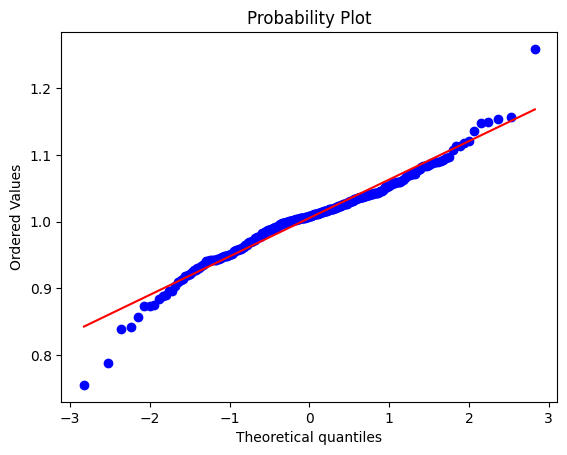

In [62]:
# Check for Normality for a given pattern, modus and day ofter occurence (Extended Version)

# results (=cumrets-values) for the combination of patter, type and day
txx = traject_1[(traject_1['pattern'] == candle) & ((traject_1['tp'] == tpx[0]) | (traject_1['tp'] == tpx[1])) & (traject_1['day'] == day)]['cumrets']
data = txx.to_numpy()

print(f' pattern:{candle}   signal-type:{mode}    day:{day}   conf.-level:{alpha}')
print('')

# Perform D’Agostino-Pearson Test
statistic, pvalue = st.normaltest(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'DAgostino & Pearson:             {result:>11s}   p: {pvalue:.5f} statistic: {statistic:.5f}')

# Perform Kolmogorov-Smirnov (-Lilliefors)-Test
ksstat, pvalue = sm.stats.diagnostic.kstest_normal(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'Kolmogorov-Smirnov-Lilliefors:   {result:>11s}   p: {pvalue:.5f} statistic: {ksstat:.5f}  ')

# perform Jarque-Bera-Test
statistic, pvalue = st.jarque_bera(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'Jarque-Bera:                     {result:>11s}   p: {pvalue:.5f} statistic: {statistic:.5f}')

# Perform Lilliefors-Test
ksstat, pvalue = sm.stats.diagnostic.lilliefors(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'Lilliefors:                      {result:>11s}   p: {pvalue:.5f} statistic: {ksstat:.5f}')

# perform Shapiro-Wilk test
statistic, pvalue = st.shapiro(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'Shapiro-Wilk:                    {result:>11s}   p: {pvalue:.5f} statistic: {ksstat:.5f}     ')

# Perform Anderson-Darling test
rx = st.anderson(data)
idx = np.where(rx.significance_level == alpha * 100)
result = 'Normal' if rx.statistic < rx.critical_values[idx] else 'NOT Normal'
print(f'Anderson–Darling:                {result:>11s}   statistic: {rx.statistic:.5f}')

# General description
results = st.describe(data)
print('')
print(f' n: {results.nobs} mean: {results.mean:.4f} var: {results.variance:4f}  min: {results.minmax[0]:.4f}  max: {results.minmax[1]:.4f} skewness: {results.skewness:.4f} kurtosis: {results.kurtosis:.4f}')
print('')

#plotting
st.probplot(data, dist='norm', plot=plt)
plt.show()

In [39]:
def norm_test(data, method, alpha):
  ''' test of null-hypothesis: data is normally distributed
  Args:
    data: to be anlyzed
    method: test method to be applied
    alpha: confidence level
  Returns:
    the test result: 1 in case the null-hypothesis is confirmed and 0 if null-hyothesis is rejected
  Raises:
    nothing
  '''
  res, statistic, pvalue = 0, 0, 0
  # perform DAgoiostino & Pearson Test for Normality
  if method == 'dAgostinoPearson':
    statistic, pvalue = st.normaltest(data)
    res = 1 if pvalue > alpha else 0
  # perform Jarque-Brera-Test for Normality
  elif method == 'JarqueBera':
    statistic, pvalue = st.jarque_bera(data)
    res = 1 if pvalue > alpha else 0
  # Perform Lilliefors-Test for Normality
  elif method == 'Lilliefors':
    statistic, pvalue = sm.stats.diagnostic.lilliefors(data)
    res = 1 if pvalue > alpha else 0
  # perform Shapiro-Wilk test for Normality
  elif method == 'ShapiroWilk':
    statistic, pvalue = st.shapiro(data)
    res = 1 if pvalue > alpha else 0
  # Perform Anderson-Darling test for Normality
  elif method == 'AndersonDarling':
    rx = st.anderson(data)
    idx = np.where(rx.significance_level == alpha * 100)
    res = 1 if rx.statistic < rx.critical_values[idx] else 0
  elif method =='KolmogorovSmirnov':
    statistic, pvalue = sm.stats.diagnostic.kstest_normal(data)
    res = 1 if pvalue > alpha else 0
  res =1 if res>0 else 0
  return int(res)


In [63]:
# test for a normal-distribution of cummulated returns for different combination of (candle-patterns, mode) and a certain day

test_names = ['dAgostinoPearsons','JarqueBera', 'Lilliefors', 'ShapiroWilk', 'AndersonDarling', 'KolmogorovSmirnov']
test_results = []
result = np.zeros(shape=(len(top_patterns), len(days_analyzed)))

for test in test_names:
  for i, candle in enumerate(top_patterns):
    result = np.zeros(shape=(len(top_patterns), len(days_analyzed)))
    tr1 = traject_1[(traject_1['pattern'] == candle) & ((traject_1['tp'] == tpx[0]) | (traject_1['tp'] == tpx[1]))]
    for j, day in enumerate(days_analyzed):
      data = tr1[tr1['day'] == day]['cumrets']
      result[i,j] = norm_test(data, test, alpha)
  test_results =  test_results + [result]


In [64]:
# plotting of the results of various tests

# preparation
test_str = ['Test: ' + str(test_names[i]) for i in range(len(test_names))]
fig = make_subplots(rows=2, cols=3, shared_yaxes=True, shared_xaxes=True, subplot_titles = (test_str))

#sub-plotting
for k, test in enumerate(test_names):
  row = int(k/3) + 1
  col = k%3 + 1
  z=[]
  fig.add_trace(go.Heatmap(z=test_results[k], zmin=0, zmax=1, x=days_analyzed, y=top_patterns, colorscale='Blues'), row=row, col=col)

title = 'Results of test for normality using different methods'
fig.update_layout(template='plotly_dark', autosize=False, width=1000, height=800)
fig.update_xaxes(title_text='days after occ', row=2, col=1)
fig.update_xaxes(title_text='days after occ', row=2, col=2)
fig.update_xaxes(title_text='days after occ', row=2, col=3)
fig.update_yaxes(title_text='pattern', row=1, col=1)
fig.update_yaxes(title_text='pattern', row=2, col=1)
fig.update_layout(title=title)
fig.update_xaxes(tickangle= -90)

fig.show()

# 5. Comparison to random trades

In [ ]:
# reference cases

# sart with top_patterns
# generierung pro top pattern eine Liste zufallsdaten (gleiche Anzahl)
# nutzung der codeblöcke oben um Traject 1 und Traject2 zu erzeugen

# dann Auswertung wie gehabt
candle = 'CDL3OUTSIDE'
stat = 100
idx = stats.index(stat)
nb_occ = int(most_active.loc[candle, most_active.columns[idx]])    # nb of occurences of candle/type combination

# simulation of nb_occ random trades
ind_rand = np.random.choice(range(len(prices)), nb_occ, replace=False).tolist()
list_dates = [prices.index[ind].date() for ind in ind_rand]


In [ ]:
# calculation of trajectories  of random trades (= rets after random selected moment in time)

# Preparations
trajct_rand = pd.DataFrame()
tr_x = pd.DataFrame()
tr_xx = pd.DataFrame()

steps = 20
col_names_rets = ['rets+'+str(i+1).zfill(2) for i in range(steps)]

# Generating Dataframe with basic data and candle trajectories
pr_x = prices[prices.index.isin(list_dates)]['Close']
dict_df = {'price': pr_x,
           'rets+00': [0] * len(list_dates)}         # at day of occurence no return
trajct_rand = pd.DataFrame(dict_df, index=list_dates)
# Generation of trajectory data (= returns from day+1 to day+steps)
for i, col_name in enumerate(col_names_rets):
  rets_x = prices['Close'].pct_change().shift(-(i+1))
  trajct_rand[col_name] = rets_x[rets_x.index.isin(list_dates)]

# preparation of renaming columns
col_names_rets.insert(0,'rets+00')
col_names_cumrets = ['cumrets+'+str(i).zfill(2) for i in range(steps+1)]
cols_renamed = dict(zip(col_names_rets, col_names_cumrets))

# calculation of the cummulated returns and renaming
tr_xx = (1 + trajct_rand[col_names_rets]).cumprod(axis=1)
tr_xx = tr_xx.rename(columns=cols_renamed)

# combining the dataframes with rets und cumrets
trajct_rand = pd.concat([trajct_rand, tr_xx], axis=1)

In [ ]:
# preparations
pos_dis_rand = pd.DataFrame()

# looping trough dandles, stats and times
tr = trajct_rand[col_names_cumrets]

for time in range(1,steps+2):
  ix = time - (steps + 1)
  p_x = tr[col_names_cumrets[-ix]].tolist()
  p_t = [time] * len(tr)
  pos_x = pd.DataFrame({'time': [-ix] * len(tr),
                        'pnl': p_x},
                       index=tr.index)
  pos_dis_rand = pd.concat([pos_dis_rand, pos_x], axis=0)


In [ ]:
main_title = 'average development of PnL of positions after random trading'
sub_title = f'instrument: DAX,  duration: 2000-01-01 - 2024-06-09 '
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# preparation
p_x = pos_dis_rand

# plotting
fig = px.box(p_x, x='time', y ='pnl')
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='days after occurence of a pattern', yaxis_title='# PnL of position', legend_title='candle pattern')
fig.update_xaxes(dtick=1, tickangle= -90)
fig.show()

In [ ]:
# distribution of positions
candle = 'CDL3OUTSIDE'
stat = 100
times = [20, 15, 10, 5, 1]
time = times[3]


main_title = 'distribution of PnL of positions after occurences of candle patterns vs random trading'
sub_title = f'instrument: DAX,  duration: 2000-01-01 - 2024-06-09   candle-pattern: {candle}'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

#preparation
p_x = pos_dis[(pos_dis['name'] == candle) & (pos_dis['stats'] == stat)]

# plotting
fig = go.Figure()
p_xx = p_x[p_x['time'] == time]
p_xxx = pos_dis_rand[pos_dis_rand['time'] == time]
fig.add_trace(go.Histogram(x=p_xx.pnl, name=f'{candle} time:+{time} days', histnorm='percent'))
fig.add_trace(go.Histogram(x=p_xxx.pnl, name=f'random trades time:+{time} days', histnorm='percent'))

fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='final PnL', yaxis_title='percentage', legend_title='time')
bargap = 0.025
bargroupgap = 0.1
fig.show()

print(f' average position {candle} after {time} days: {p_xx.pnl.mean()}')
print(f' average position random trade after {time} days: {p_xxx.pnl.mean()}')


 average position CDL3OUTSIDE after 5 days: 1.00214138337652
 average position random trade after 5 days: 1.0039285447128643
